In [1]:
import time
import itertools
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from z3ml.train import train
from z3ml.models import z3MultiClassLinear
from z3ml.losses import multiclass_loss
from z3 import *

# Functions, vars 

In [3]:
seed = 42

In [4]:
def quantize_X(x, b=8):

    x = torch.tensor(x)
    
    xq = torch.empty((x.size(0), x.size(1)))
    xd = torch.empty((x.size(0), x.size(1)))

    s=(2**b-1)/torch.max(abs(x), axis=0).values
    xq = torch.round(s * x[:, None])
    xd = xq / s

    xq = xq.squeeze(1).numpy()
    xd = xd.squeeze(1).numpy()

    return xq, xd

In [5]:
def plot_run_result(df_overall, df_per_class):
    
    f, axes = plt.subplots(1,3, figsize=(20,5))
    df_overall[['construct_time','solve_time']].plot(ax=axes[0])
    axes[0].set_title("Solver time")
    axes[0].set_ylabel("Time (sec)")

    df_overall[['test_acc']].plot(ax=axes[1])
    axes[1].set_title("Test accuracy")
    axes[1].set_xlabel("# sample per class")

    df_per_class.plot.bar(ax=axes[2])
    axes[2].set_title("Per class accuracy by # samples in each class")
    plt.show()

In [6]:
def construct_train_set(train_x_org, train_lab_org, num_per_class, cls = np.arange(0,10,1)):
    
    train_samples = []
    train_labs = []

    for c in cls:
        target_indices = torch.nonzero(train_lab_org == c).flatten()
        subset = torch.randperm(target_indices.size(0))[:num_per_class]
        target_y = train_lab_org[target_indices[subset]]
        target_x = train_x_org[target_indices[subset]]
        train_samples.append(target_x)
        train_labs.append(target_y)
    
    train_samples = torch.cat(train_samples).numpy()
    train_labs = torch.cat(train_labs).numpy()
    
    return train_samples,train_labs

In [7]:
def calculate_per_class_accuracy(pred, target, prefix):

    df = pd.DataFrame(torch.transpose(torch.stack([pred, target]), 1, 0), columns=['pred','target'])
    df[f'acc_{prefix}'] = np.where(df['pred']==df['target'], 1, 0)
    per_cls_acc = df.groupby('target').agg({f'acc_{prefix}':'mean'})

    return per_cls_acc.T

In [8]:
np.arange(1, 100, 10)

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [9]:
def run_experiment(train_x, train_y, test_x, test_y, cls,
                   num_per_class_all=np.arange(1, 100, 10),
                   num_features=784, use_quantize = False, use_optimize=False, pca_dim = None,
                   dtype=Real):
    construct_time = []
    solve_time = []
    test_acc = []
    sat_ls = []
    sample_num =[]
    df_cls_acc_ls = []
    model_ls = []
    model_features = []

    if pca_dim:
        pca = PCA(n_components=pca_dim)
        train_x = pca.fit_transform(train_x.data.flatten(start_dim=1))
        test_x = pca.fit_transform(test_x.data.flatten(start_dim=1))
        train_x = torch.tensor(train_x)
        test_x = torch.tensor(test_x)

    for num_per_class in num_per_class_all:#range(1,max_sample,10):
        
        # 1. Prepare the samples
        train_samples, train_labels = construct_train_set(train_x, train_y, num_per_class, cls)
        sample_num.append(train_samples.shape[0]/len(cls))

        if use_quantize:
            train_samples, _ = quantize_X(train_samples)
            test_x, _ = quantize_X(test_x)
        
        # 2. Construct the terms
        ml = z3MultiClassLinear(num_features, len(cls), dtype=dtype)
        tic = time.time()
        terms = train(train_samples, train_labels, ml, multiclass_loss)
        toc = time.time()
        construct_time.append(toc-tic)
        # print(f"Train size {train_samples.shape[0]} constructed in {toc-tic}")

        # 3. Solve the constraint
        if use_optimize:
            s = Optimize() 
            for i, ts in enumerate(terms):
                for j, t in enumerate(ts):
                    if j == (len(ts) - 1):
                        s.add_soft(t)
                    else:
                        s.add(t)
        else:
            s = Solver()
            s.set("timeout", 60000) # timeout 1 minute
            s.add(*itertools.chain(*terms))
            
        tic = time.time()
        status = s.check()
        toc = time.time()
        solve_time.append(toc-tic)
        sat_ls.append(status)
        # print(f"status: {status}")

        # 4. Evaluate accuracy
        if status==sat:
            ml = ml.realize(s.model())
            nonzero_idx = torch.nonzero(torch.tensor(ml.parameters['w']))
            model_features.append(nonzero_idx.shape[0]) # get the number of nonzero entries
            model_ls.append(ml)

            # prediction step: overall accuracy and per-class accuracy
            cls_idx = [idx for idx, i in enumerate(test_y) if i in cls]
            y_pred = ml.predict(test_x[cls_idx])
            acc = float(sum(y_pred==test_y[cls_idx])/len(y_pred))
            y_correct = test_y[cls_idx].clone().detach()
            y_pred = torch.tensor(y_pred).clone().detach() # torch.tensor
            acc_by_cls = calculate_per_class_accuracy(pred=y_pred, target=y_correct, prefix=num_per_class)

            test_acc.append(acc) 
            df_cls_acc_ls.append(acc_by_cls)
        else:
            model_features.append(None)
            model_ls.append(None)
            test_acc.append(None)
            
    
    df = pd.DataFrame([sample_num, construct_time, solve_time, test_acc, sat_ls, model_features],
                           index=['sample_num','construct_time','solve_time','test_acc','sat_ls', 'num_nonzero_param']).T
    df = df.set_index('sample_num')
    if len(df_cls_acc_ls)> 0:
        df_cls = pd.concat(df_cls_acc_ls)
    else:
        df_cls = None

    return df, df_cls, model_ls

## Actual data for multi-class classification

A few problems:
1. Model very slow in distinguishing between a few classes
2. Exp increasing solve time

## Load data

In [10]:
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True)

In [11]:
train_x= trainset.data.flatten(start_dim=1)
train_y = trainset.targets

test_x = train_x[50000:,:]
test_y = train_y[50000:,]
train_x = train_x[:50000,:]
train_y = train_y[:50000,]

print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)

torch.Size([10000, 784])
torch.Size([10000])
torch.Size([50000, 784])
torch.Size([50000])


**A few observations...**

*Overall*
* More data samples don't necessarily mean good performance on the test set. We have to get "lucky" with our training samples for the model to do well.
    * TODO: check if there's a notable difference in the traing sample of a model that achieves high accuracy
* As # classes increase, have more UNSAT instances if the data dimension is restricted (say fixed at 5 with PCA). A solver need to handle non-separable case (Optimize) or the data dimension should increase (i.e. use random projection) to solve instances with many classes.
    * Caveat: tried Optimize() and it's muchx100 slower.

* Interestingly, the weight parameters found by the solver have a many zero entries if the problem is "easy" (can do with few parameters). As the problem gets harder (# classes increase), the % of nonzero parameters increase and the solver eventually returns unsat.
    **min # nonzero model weights for a given problem (PCA dim=5)**
    * 2 class: 2 parmaeters (out of 5 * 2 = 10 params)
    * 3 class: 10 parameters (higher # unsat, out of 5*3 = 15 params)
    * 4 class: 15 parameters (out of 5*4 = 20 possible params; higher instances of sat, 14 param still with PCA 6)
    * 5 class: ...
    * 6 class:
    * 7 class:
    * 8 class:
    * 9 class:

*Testing the method on other real-world single class  datasets*
* Tried this, but have not found an interesting dataset yet. For instance, solver is not very good at fraud detection.

*Other observations*
* Models are not consistently good at separating one class. In this case, can we just use a bagging method to boost the accuracy of the weak models? <<- theoretical approach


## Example

In [12]:
# two class classification -- without PCA
df01, df01_cls, model01_ls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       cls=[0,1], num_per_class_all=[10,20,30,40,50])

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/3483631185.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred).clone().detach() # torch.tensor
/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/3483631185.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred).clone().detach() # torch.tensor
/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/3483631185.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred).clo

,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param
sample_num,,,,,
10.0,2.458221,0.394197,0.603893,sat,37
20.0,5.059174,1.63635,0.6,sat,40
30.0,8.079661,3.249097,0.499757,sat,63
40.0,10.928303,4.646552,0.592214,sat,89
50.0,13.212952,7.917849,0.583455,sat,93


target,0,1
acc_10,0.617558,0.591165
acc_20,0.464178,0.726504
acc_30,0.448032,0.547932
acc_40,0.502523,0.675752
acc_50,0.511604,0.650376


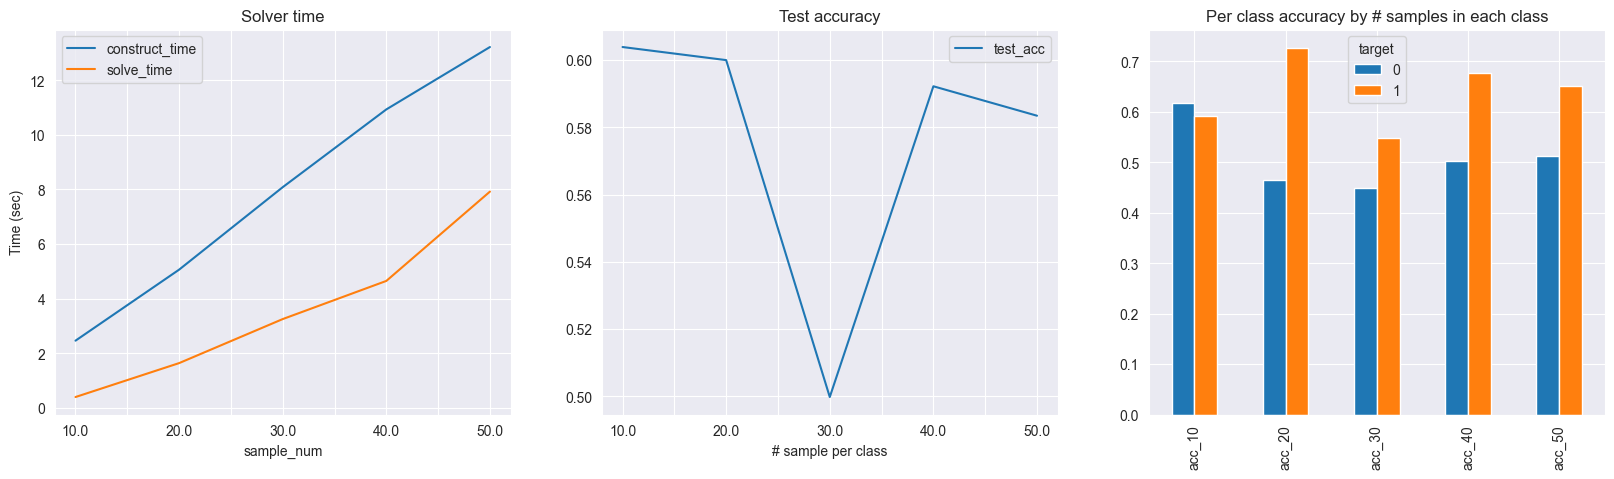

In [13]:
display(df01)
display(df01_cls)
plot_run_result(df01, df01_cls)

## Experiment: 2 classes
int vs. real / varying # dimensions / varying # samples

In [14]:
# two class classification -- with PCA
res_ls = []
cls_ls = []
for i in [1,2,3,4,5]:
    for d in [Real, Int]:
        temp_res, temp_cls, model_ls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                            num_features=i, use_quantize=True, cls=[0,1], num_per_class_all=[10,20,30], pca_dim = i)
        temp_res['total_time'] = temp_res['solve_time']+temp_res['construct_time']
        temp_res['num_features'] = i
        temp_res['real_vs_int'] = 'real' if d == Real else 'int'

        temp_cls['num_features'] = i
        temp_cls['real_vs_int'] = 'real' if d == Real else 'int'
        res_ls.append(temp_res)
        cls_ls.append(temp_cls)
        
        print(f"PCA dimension {i}, Dtype {d}")

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 1, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 1, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 2, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 2, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 3, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 3, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 4, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 4, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 5, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 5, Dtype <function Int at 0x16af69240>


In [15]:
df01 = pd.concat(res_ls).reset_index()
df01.to_json('data/class01.json')
display(df01)

,sample_num,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param,total_time,num_features,real_vs_int
0,10.0,0.037699,0.023336,0.988808,sat,2,0.061035,1,real
1,20.0,0.053658,0.032714,0.961557,sat,2,0.086372,1,real
2,30.0,0.052691,0.040158,0.993187,sat,2,0.092849,1,real
3,10.0,0.041233,0.050771,0.965937,sat,2,0.092005,1,int
4,20.0,0.038694,0.038973,0.973723,sat,2,0.077667,1,int
5,30.0,0.058316,0.052156,0.992701,sat,1,0.110472,1,int
6,10.0,0.041059,0.055384,0.988321,sat,3,0.096443,2,real
7,20.0,0.042492,0.048902,0.976156,sat,4,0.091394,2,real
8,30.0,0.061543,0.073801,0.991241,sat,4,0.135344,2,real
9,10.0,0.03232,0.067597,0.96399,sat,4,0.099917,2,int


## 4 classes
int vs. real / varying # dimensions / varying # samples

In [16]:
res_ls = []
cls_ls = []
for i in [1,2,3,4,5]:
    for d in [Real, Int]:
        print(f"PCA dimension {i}, Dtype {d}")
        temp_res, temp_cls, model_ls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                            num_features=i, use_quantize=True, cls=[0,1,2,3], num_per_class_all=[10,20,30], pca_dim = i)
        temp_res['total_time'] = temp_res['solve_time']+temp_res['construct_time']
        temp_res['num_features'] = i
        temp_res['real_vs_int'] = 'real' if d == Real else 'int'

        if temp_cls is not None:
            temp_cls['num_features'] = i
            temp_cls['real_vs_int'] = 'real' if d == Real else 'int'
            cls_ls.append(temp_cls)
        res_ls.append(temp_res)

PCA dimension 1, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 1, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 2, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 2, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 3, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 3, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 4, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 4, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 5, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 5, Dtype <function Int at 0x16af69240>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [17]:
df03 = pd.concat(res_ls).reset_index()
df03.to_json('data/class03.json')
display(df03)

,sample_num,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param,total_time,num_features,real_vs_int
0,10.0,0.117794,0.080523,None,unsat,None,0.198317,1,real
1,20.0,0.169755,0.188261,None,unsat,None,0.358016,1,real
2,30.0,0.198464,0.184838,None,unsat,None,0.383302,1,real
3,10.0,0.111121,0.106368,None,unsat,None,0.217489,1,int
4,20.0,0.135975,0.100416,None,unsat,None,0.236391,1,int
5,30.0,0.194077,0.123711,None,unsat,None,0.317788,1,int
6,10.0,0.135355,0.095722,None,unsat,None,0.231077,2,real
7,20.0,0.182956,0.1546,None,unsat,None,0.337556,2,real
8,30.0,0.40562,0.310079,None,unsat,None,0.715699,2,real
9,10.0,0.148029,0.100963,None,unsat,None,0.248992,2,int


## 6 classes
int vs. real / varying # dimensions / varying # samples

In [21]:
res_ls = []
cls_ls = []
for i in [6]:
    for d in [Real, Int]:
        temp_res, temp_cls, model_ls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                            num_features=i, use_quantize=True, cls=[0,1,2,3,4,5], num_per_class_all=[10,20], pca_dim = i)
        temp_res['total_time'] = temp_res['solve_time']+temp_res['construct_time']
        temp_res['num_features'] = i
        temp_res['real_vs_int'] = 'real' if d == Real else 'int'
        if temp_cls is not None:
            temp_cls['num_features'] = i
            temp_cls['real_vs_int'] = 'real' if d == Real else 'int'
            cls_ls.append(temp_cls)
        res_ls.append(temp_res)
                
        print(f"PCA dimension {i}, Dtype {d}")

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 6, Dtype <function Real at 0x16af69480>


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


PCA dimension 6, Dtype <function Int at 0x16af69240>


In [22]:
df05 = pd.concat(res_ls).reset_index()
df05.to_json('data/class05.json')
display(df05)

,sample_num,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param,total_time,num_features,real_vs_int
0,10.0,0.428666,198.953414,None,unsat,None,199.38208,6,real
1,20.0,0.755412,6.990511,None,unsat,None,7.745923,6,real
2,10.0,0.478044,112.926055,None,unsat,None,113.404099,6,int
3,20.0,0.737439,855.289147,None,unsat,None,856.026586,6,int


In [19]:
df05 = pd.concat(res_ls).reset_index()
df05.to_json('data/class05.json')
display(df05)

,sample_num,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param,total_time,num_features,real_vs_int
0,10.0,0.251143,0.121902,None,unsat,None,0.373045,1,real
1,20.0,0.285761,0.308977,None,unsat,None,0.594738,1,real
2,30.0,0.427219,0.36216,None,unsat,None,0.789379,1,real
3,10.0,0.24259,0.150742,None,unsat,None,0.393332,1,int
4,20.0,0.276215,0.269414,None,unsat,None,0.545629,1,int
5,30.0,0.484421,0.321811,None,unsat,None,0.806232,1,int
6,10.0,0.296915,0.205262,None,unsat,None,0.502177,2,real
7,20.0,0.549915,0.389887,None,unsat,None,0.939802,2,real
8,30.0,0.530122,0.701241,None,unsat,None,1.231363,2,real
9,10.0,0.301486,0.169147,None,unsat,None,0.470633,2,int


## 8 classes
int vs. real / varying # dimensions / varying # samples

In [20]:
res_ls = []
cls_ls = []
for i in [1,2,3,4,5]:
    for d in [Real, Int]:
        temp_res, temp_cls, model_ls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                            num_features=i, use_quantize=True, cls=[0,1,2,3,4,5,6,7],  num_per_class_all=[10,20,30], pca_dim = i)
        temp_res['total_time'] = temp_res['solve_time']+temp_res['construct_time']
        temp_res['num_features'] = i
        temp_res['real_vs_int'] = 'real' if d == Real else 'int'


        if temp_cls is not None:
            temp_cls['num_features'] = i
            temp_cls['real_vs_int'] = 'real' if d == Real else 'int'
            cls_ls.append(temp_cls)
        res_ls.append(temp_res)
        
        print(f"PCA dimension {i}, Dtype {d}")
df07 = pd.concat(res_ls).reset_index()
df07.to_json('data/class07.json')
display(df07)

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_89302/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


TypeError: 'NoneType' object does not support item assignment

## 10 classes
int vs. real / varying # dimensions / varying # samples

In [14]:
res_ls = []
cls_ls = []
for i in [1,2,3,4,5]:
    for d in [Real, Int]:
        temp_res, temp_cls, model_ls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                            num_features=i, use_quantize=True, cls=[0,1,2,3,4,5,6,7,8,9],  num_per_class_all=[10,20], pca_dim = i)
        temp_res['total_time'] = temp_res['solve_time']+temp_res['construct_time']
        temp_res['num_features'] = i
        temp_res['real_vs_int'] = 'real' if d == Real else 'int'

        temp_cls['num_features'] = i
        temp_cls['real_vs_int'] = 'real' if d == Real else 'int'
        res_ls.append(temp_res)
        cls_ls.append(temp_cls)
        
        print(f"PCA dimension {i}, Dtype {d}")
df09 = pd.concat(res_ls).reset_index()
df09.to_json('data/class09.json')

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_68073/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


TypeError: 'NoneType' object does not support item assignment

#  Fixed PCA dimension, varying sample sizes

In [12]:
# two class classification -- with PCA 
df01_pca, df01_cls_pca, model01_pls = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1], num_per_class_all=[100])

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_87265/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [13]:
for i in range(len(model01_pls)):
    temp = torch.tensor(model01_pls[i].parameters['w'])
    nonzero_idx = torch.nonzero(temp)
    print(nonzero_idx.shape)
    print(model01_pls[i].parameters['b'])
    # print(temp[nonzero_idx]) # 154, 156th weights are nonzero --

torch.Size([7, 2])
[ 0.         -1.20778828]


In [14]:
temp = torch.tensor(model01_pls[0].parameters['w'])
nonzero_idx = torch.nonzero(temp)
print(nonzero_idx)
temp

,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param
sample_num,,,,,
100.0,0.401396,3.291657,0.989294,sat,7


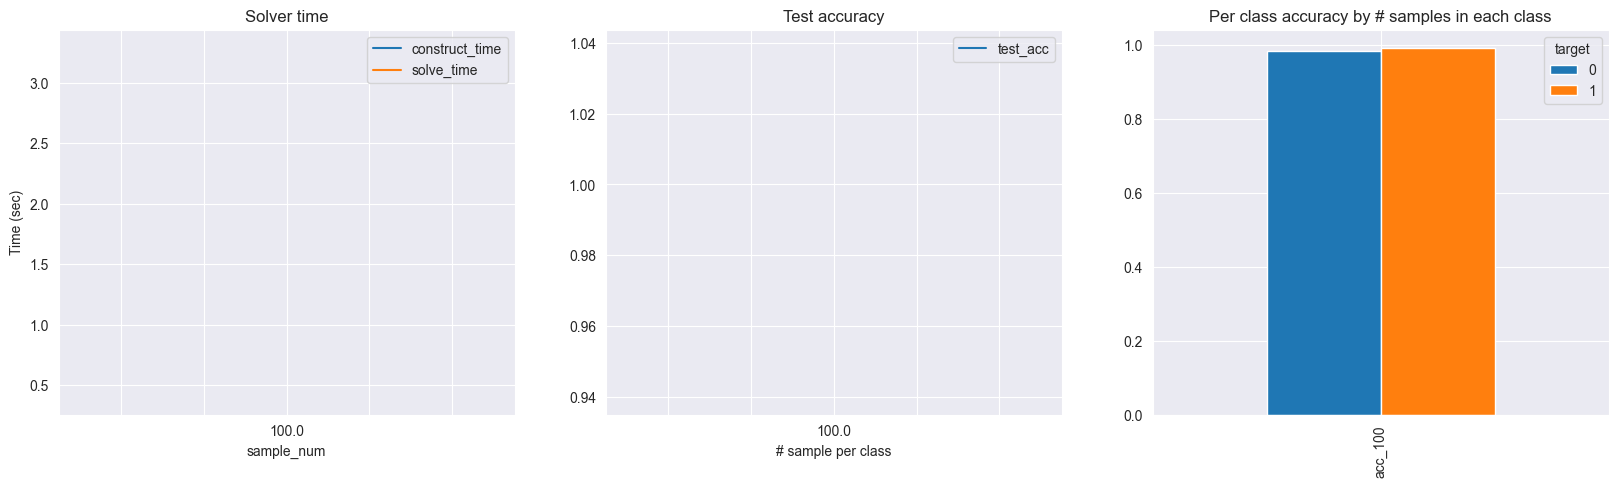

In [16]:
display(df01_pca)
plot_run_result(df01_pca, df01_cls_pca)

In [23]:
# three class classification -- with PCA 
df02_pca, df02_cls_pca, model02_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2], num_per_class_all=[10,20,30])

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_87265/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [24]:
for i in range(len(model02_pca)):
    if model02_pca[i] != None:
        temp = torch.tensor(model02_pca[i].parameters['w'])
        nonzero_idx = torch.nonzero(temp)
        print(nonzero_idx.shape)
        print(model02_pca[i].parameters['b'])
        # print(temp[nonzero_idx]) # 154, 156th weights are nonzero --

torch.Size([10, 2])
[ 0.         34.19860208 34.77965514]
torch.Size([12, 2])
[-5.63023503  0.          2.50504517]
torch.Size([10, 2])
[ 0.         -4.59148186  1.02526908]


In [25]:
display(torch.tensor(model02_pca[0].parameters['w']))

tensor([[ 0.0000, -0.2156, -0.2121],
        [ 0.0000,  0.1054,  0.1023],
        [ 0.0000,  0.0852,  0.0919],
        [ 0.0000,  0.0846,  0.0822],
        [ 0.0000,  0.0960,  0.1001]], dtype=torch.float64)

,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param
sample_num,,,,,
10.0,0.150997,0.252504,0.628571,sat,10
20.0,0.13784,0.851432,0.904433,sat,12
30.0,0.219975,1.284562,0.915599,sat,10


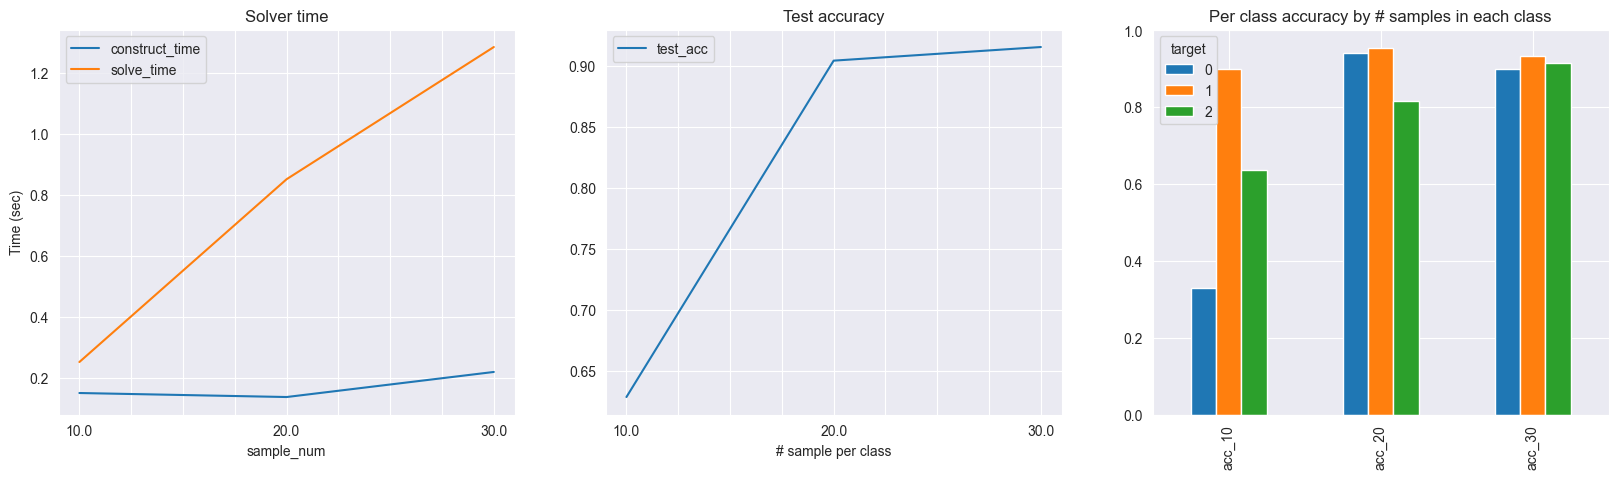

In [26]:
display(df02_pca) # higher unsat instance
plot_run_result(df02_pca, df02_cls_pca)

In [27]:
# four class classification -- with PCA
df03_pca, df03_cls_pca, model03_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3], num_per_class_all=[10,20,30])

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_87265/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [28]:
for i in range(len(model03_pca)):
    if model03_pca[i] != None:
        temp = torch.tensor(model03_pca[i].parameters['w']) # 15 of them are nonzero (out of 5*4 = 20 possible slots)
        nonzero_idx = torch.nonzero(temp)
        print(nonzero_idx.shape)
        print(model03_pca[i].parameters['b'])
        # print(temp[nonzero_idx]) # 154, 156th weights are nonzero --

torch.Size([15, 2])
[ 0.         -8.87715593 -7.08045911 -1.29376834]


In [29]:
torch.tensor(model03_pca[0].parameters['w'])

tensor([[ 0.0000, -0.4036, -0.3748, -0.0153],
        [ 0.0000, -0.0444, -0.0404,  0.0181],
        [ 0.0000, -0.0352, -0.0418,  0.0094],
        [ 0.0000, -0.1750, -0.1779,  0.0103],
        [ 0.0000,  0.1844,  0.1889,  0.0026]], dtype=torch.float64)

,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param
sample_num,,,,,
10.0,0.181556,0.821555,0.778405,sat,15
20.0,0.274464,5.456059,None,unsat,None
30.0,0.37245,2.524072,None,unsat,None


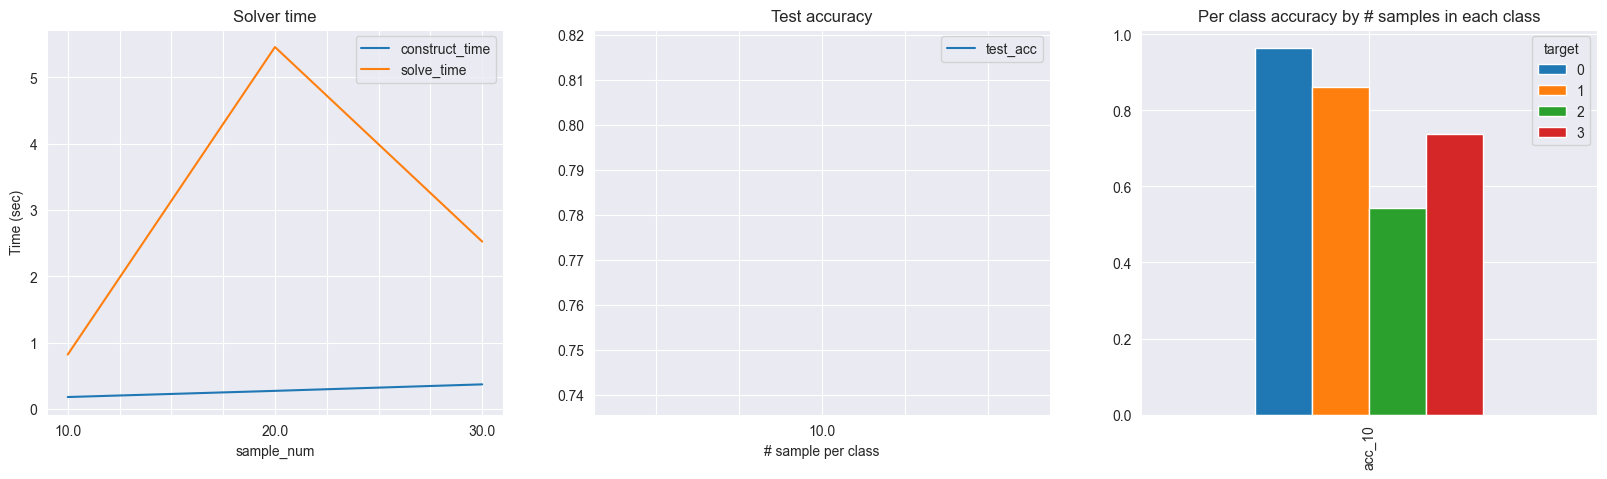

In [31]:
display(df03_pca)
plot_run_result(df03_pca, df03_cls_pca) # max acc was 0.76

In [32]:
df04_pca, df04_cls_pca, model = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3,4], num_per_class_all=[10,20,30])

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_87265/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [33]:
for i in range(len(model)):
    if model[i] != None:
        temp = torch.tensor(model[i].parameters['w']) # 15 of them are nonzero (out of 5*4 = 20 possible slots)
        nonzero_idx = torch.nonzero(temp)
        print(nonzero_idx.shape)
        print(model[i].parameters['b'])
        # print(temp[nonzero_idx]) # 154, 156th weights are nonzero --

torch.Size([20, 2])
[  0.         -31.35516939  -0.89719399 -33.27432641 -63.98918048]


,construct_time,solve_time,test_acc,sat_ls,num_nonzero_param
sample_num,,,,,
10.0,0.327047,1.289717,0.488928,sat,20
20.0,0.375946,50.500026,None,unsat,None
30.0,0.802651,48.061745,None,unsat,None


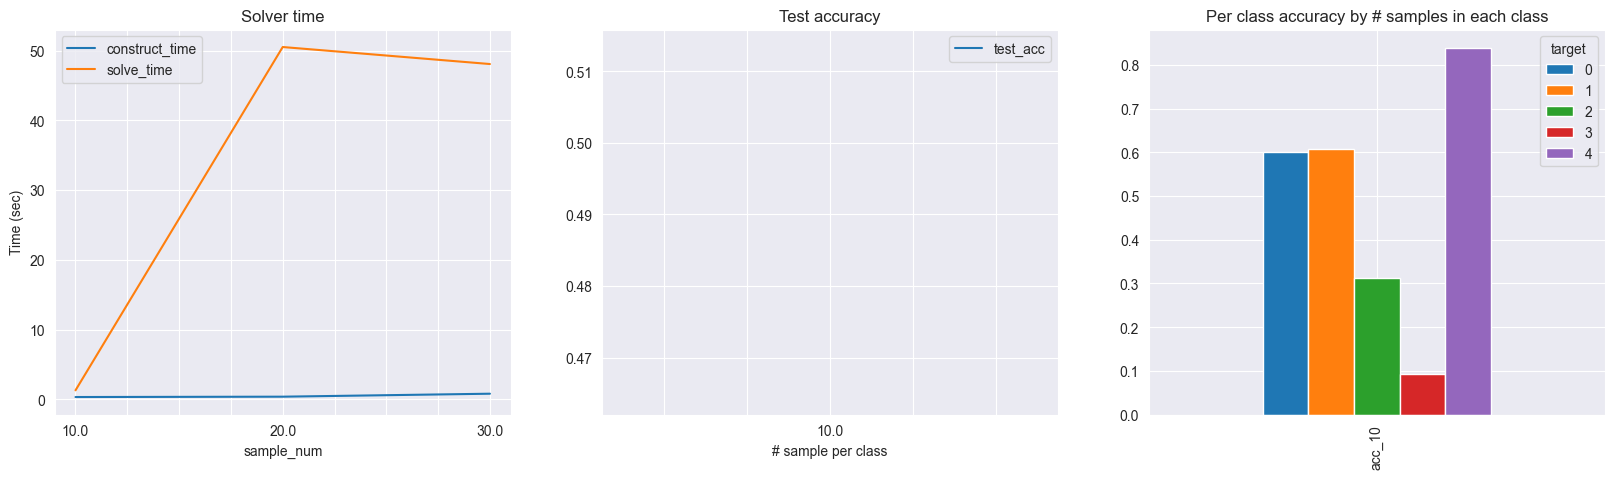

In [34]:
display(df04_pca)
plot_run_result(df04_pca, df04_cls_pca) # max was 68%

In [ ]:
# four class classification -- with PCA 
df05_pca, df05_cls_pca, model05_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3,4,5], num_per_class_all=[10,20,30])
display(df05_pca)
plot_run_result(df05_pca, df05_cls_pca) # 30% max acc

/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_87265/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [137]:
for i in range(len(model05_pca)):
    if model05_pca[i] != None:
        temp = torch.tensor(model05_pca[i].parameters['w'])
        nonzero_idx = torch.nonzero(temp)
        print(nonzero_idx.shape)
        print(model05_pca[i].parameters['b'])
        # print(temp[nonzero_idx]) # 154, 156th weights are nonzero --

torch.Size([21, 2])
[10.60943736 -4.95160364 -0.43383043 -0.50128738 -3.35810963 -0.8493136 ]
torch.Size([30, 2])
[   0.         -226.24282324   -1.69918229  -33.16658407   -7.05188968
    0.66811552]


(7, 6)
Train size 7 constructed in 0.06972098350524902


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_39770/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


status: sat
(77, 6)
Train size 77 constructed in 0.5222198963165283
status: unsat
(147, 6)
Train size 147 constructed in 1.0447368621826172
status: unsat


,construct_time,solve_time,test_acc,sat_ls
sample_num,,,,
1.0,0.069721,0.082923,0.337608,sat
11.0,0.52222,119.784097,None,unsat
21.0,1.044737,158.114613,None,unsat


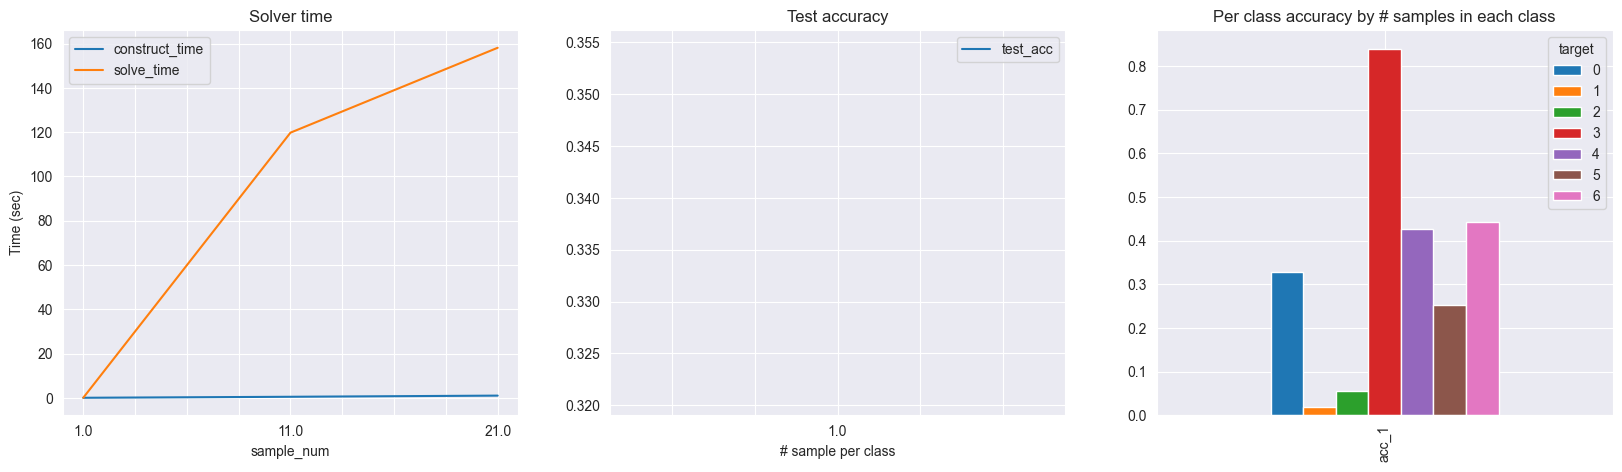

In [138]:
# four class classification -- with PCA 
df06_pca, df06_cls_pca, model06_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3,4,5,6], num_per_class_all=[10,20,30])
display(df06_pca)
plot_run_result(df06_pca, df06_cls_pca) # 20% max acc

(8, 6)
Train size 8 constructed in 0.08159399032592773


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_39770/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


status: sat
(88, 6)
Train size 88 constructed in 0.7954049110412598
status: unsat


,construct_time,solve_time,test_acc,sat_ls
sample_num,,,,
1.0,0.081594,0.13396,0.140473,sat
11.0,0.795405,1125.062062,None,unsat


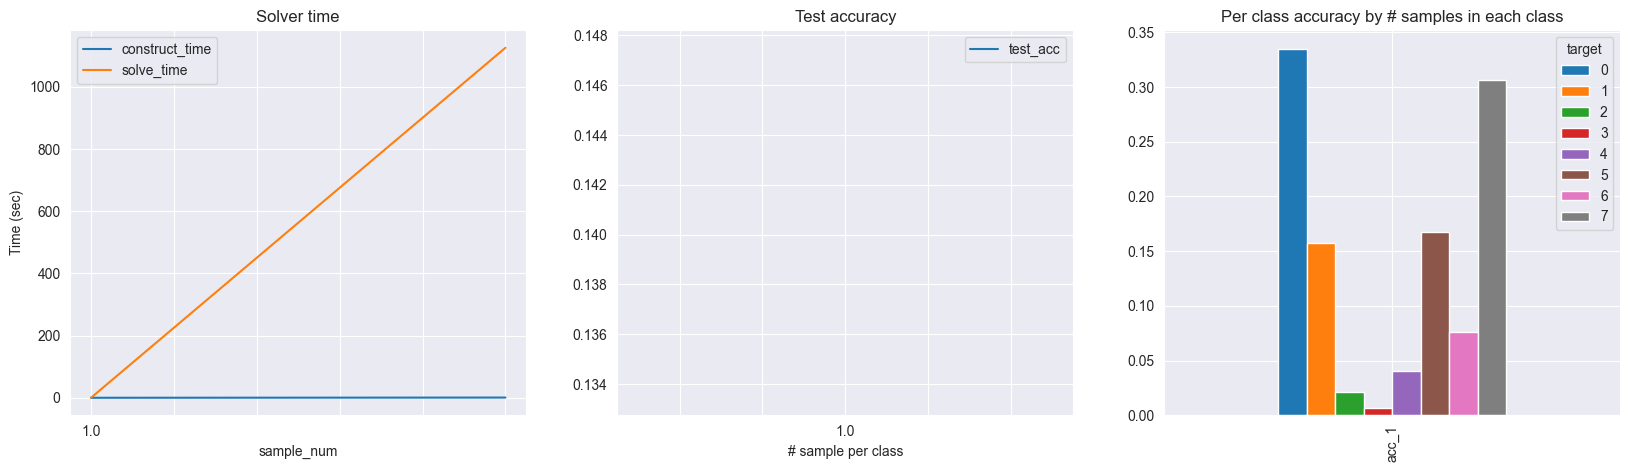

In [140]:
# four class classification -- with PCA 
df07_pca, df07_cls_pca, model07_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3,4,5,6,7], num_per_class_all=[10,20,30])
display(df07_pca)
plot_run_result(df07_pca, df07_cls_pca) # 50% max acc

(9, 6)


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_39770/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


Train size 9 constructed in 0.23497724533081055
status: sat
(99, 6)
Train size 99 constructed in 0.9989640712738037
status: unsat


,construct_time,solve_time,test_acc,sat_ls
sample_num,,,,
1.0,0.234977,0.378925,0.263414,sat
11.0,0.998964,67.852489,None,unsat


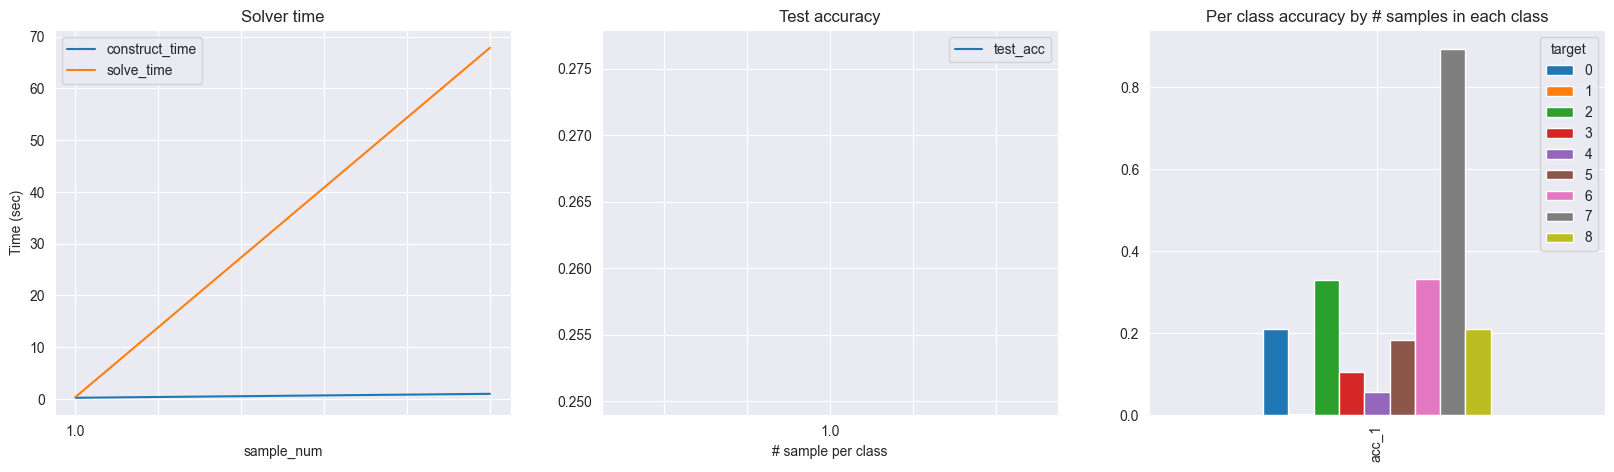

In [142]:
df08_pca, df08_cls_pca, model08_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3,4,5,6,7,8], num_per_class_all=[10,20,30])
display(df08_pca)
plot_run_result(df08_pca, df08_cls_pca) # 20% max acc

(10, 6)
Train size 10 constructed in 0.13933086395263672


/var/folders/gn/svggpq2x6t70nx58chxgxvq00000gq/T/ipykernel_39770/1308197577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


status: sat
(110, 6)
Train size 110 constructed in 1.8679454326629639
status: unsat


,construct_time,solve_time,test_acc,sat_ls
sample_num,,,,
1.0,0.139331,0.183779,0.1457,sat
11.0,1.867945,17494.351798,None,unsat


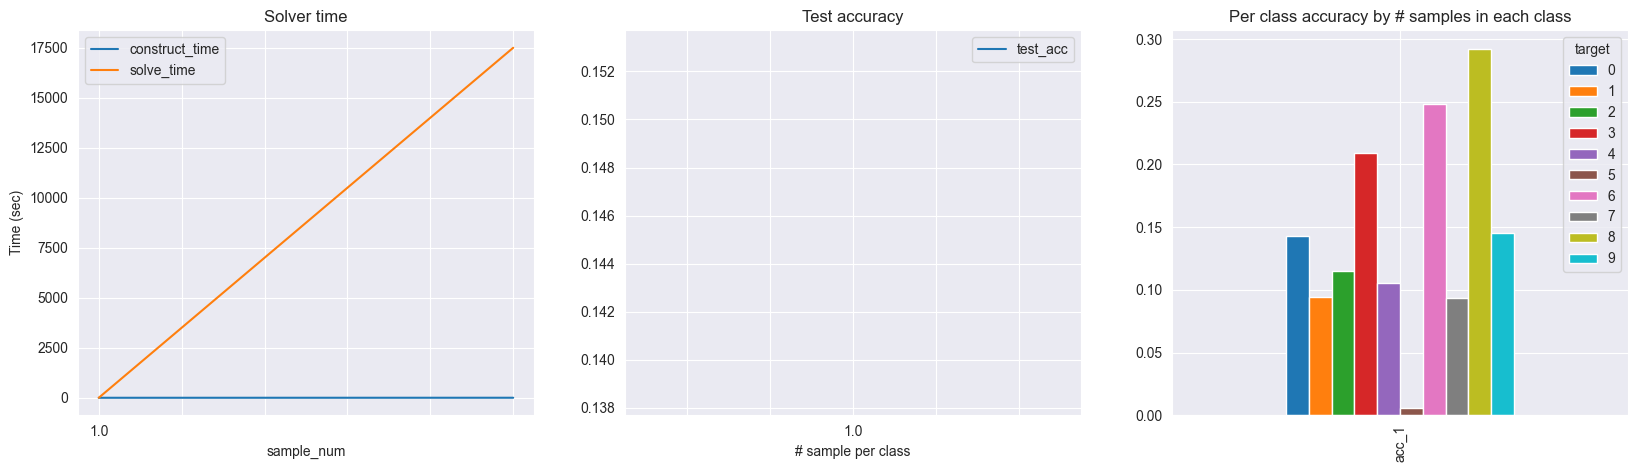

In [144]:
# four class classification -- with PCA 
df09_pca, df09_cls_pca, model09_pca = run_experiment(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y,
                                       num_features=5, use_quantize=True, pca_dim=5, cls=[0,1,2,3,4,5,6,7,8,9], num_per_class_all=[10,20,30])
display(df09_pca)
plot_run_result(df09_pca, df09_cls_pca) # 14%

In [145]:
for i in range(len(model09_pca)):
    if model09_pca[i] != None:
        temp = torch.tensor(model09_pca[i].parameters['w'])
        nonzero_idx = torch.nonzero(temp)
        print(nonzero_idx.shape)
        print(model09_pca[i].parameters['b'])
        # print(temp[nonzero_idx]) # 154, 156th weights are nonzero --

torch.Size([51, 2])
[ -0.62109455  -0.98871414  -1.27851741 -22.14642     -0.56972886
  -6.89780342  -1.5674798   -0.71075833  -0.40963159  -0.39933576]
